## Dự đoán biến động giá cổ phiếu trên sàn HOSE sử dụng phân tích cảm xúc từ tin tức tài chính trên báo Vietnam Investment Review.


**Data Description**
- **Close**: Giá thị trường của VnIndex tại thời điểm đóng cửa phiên giao dịch trên sàn HOSE.
- **Open**: Giá thực hiện hiện tại của lệnh khớp đầu tiên trong ngày giao dịch chứng khoán.
- **High**: Giá cao nhất đạt được trong phiên giao dịch hoặc trong khoảng thời gian theo dõi biến động giá.
- **Low**: Giá thấp nhất đạt được trong phiên giao dịch hoặc trong khoảng thời gian theo dõi biến động giá.
- **Change**: Sự thay đổi giá trị thị trường là sự chênh lệch giữa giá đóng cửa của VnIndex trong ngày này và giá đóng cửa của ngày hôm sau khi nó được giao dịch.
- **description**: Phần tóm tắt của các bài báo được đăng tải trên Vietnam Investment Review
- **label**: Biến thể hiện thay đổi của VnIndex, bằng 1 nếu VnIndex tăng hoặc giữ nguyên và 0 biểu thị nếu giá VnIndex giảm..


In [2]:
!pip install nltk


In [3]:
!pip install wordcloud


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
from nltk.corpus import stopwords
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import seaborn as sn

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [6]:
!pip install pandas

In [7]:
!pip install openpyxl

In [8]:
import pandas as pd

## THỰC HIỆN CRAWL DATA LÀ CÁC TIÊU ĐỀ PHẦN TÓM TẮT VÀ NGÀY PHÁT HÀNH CÁC BÀI BÁO TRÊN TRANG WEB Vietnam Investment Review - VIR

Báo "Vietnam Investment Review" (VIR) phát hành hàng tuần vào thứ Hai. Là tờ báo kinh tế bằng tiếng Anh, phản ánh hoạt động của cộng đồng doanh nghiệp tại Việt Nam, đặc biệt chú trọng đến các doanh nghiệp có vốn đầu tư nước ngoài và các chính sách kinh tế ảnh hưởng đến họ. VIR hiện được đánh giá là tờ báo tiếng Anh chuyên nghiệp nhất tại thị trường Việt Nam. Ngay từ khi ra đời, VIR đã được các nhà đầu tư nước ngoài tại Việt Nam và các tập đoàn quốc tế quan tâm đến thị trường Việt Nam đón nhận.

In [324]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

def crawl_articles_from_link(base_link):
    driver = webdriver.Chrome()
    driver.get(base_link)
    data = []

    page_number = 0
    while page_number <= 4400:
        try:
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "article")))

            soup = BeautifulSoup(driver.page_source, "html.parser")
            news_articles = soup.find_all("div", class_="article")

            for article in news_articles:
                title_element = article.find("a", class_="article-link")
                date_element = article.find("span", class_="article-date")
                article_desc = article.find("div", class_="article-desc")

                if title_element and date_element and article_desc:
                    title = title_element.get('title')
                    date = date_element.text.strip()
                    description = article_desc.text.strip()
                    data.append({"title": title, "date": date, "description": description})

            page_number += 10
            next_page_link = f"{base_link}&s_cond=&BRSR={page_number}"

            if page_number > 4400:
                break  

            driver.get(next_page_link)
            time.sleep(2)  
        except (NoSuchElementException, TimeoutException):
            print("Không tìm thấy nút next-page hoặc hết bài viết")
            break

    driver.quit()

    df = pd.DataFrame(data)
    df.to_excel('articles.xlsx', index=False)  
    print("Đã lưu dữ liệu vào file articles.xlsx")

crawl_articles_from_link("https://vir.com.vn/investing")


Đã lưu dữ liệu vào file articles.xlsx


In [215]:
df = pd.read_excel("articles.xlsx")
print (df)

                      Date                                              title  \
0     May 31, 2024 | 11:56  Mitsubishi Corporation expands operations in V...   
1     May 31, 2024 | 11:33  France provides €10 million to build Hanoi Met...   
2     May 30, 2024 | 18:37   Cooperation crucial to claim camera market slice   
3     May 30, 2024 | 18:25  Mitsubishi Materials Corporation spends $134.5...   
4     May 30, 2024 | 16:05              China speeds up investment in Vietnam   
...                    ...                                                ...   
5272  May 29, 2020 | 10:00  Dutch at forefront of new EU investment activi...   
5273  May 30, 2020 | 15:56  January-May foreign investment inflows reach $...   
5274  May 30, 2020 | 08:00  Gradual but radical changes set to sweep pharm...   
5275  May 29, 2020 | 10:00  Dutch at forefront of new EU investment activi...   
5276  May 29, 2020 | 08:00  New wave of EU investment whipped up by coming...   

                           

In [216]:
def convert_date(date_str):
    date_part = pd.to_datetime(date_str.split('|')[0].strip()).strftime('%m/%d/%Y')
    month, day, year = date_part.split('/')
    month = str(int(month))
    day = str(int(day))
    return f"{month}/{day}/{year}"
df['Date'] = df['Date'].apply(convert_date)
print(df)

           Date                                              title  \
0     5/31/2024  Mitsubishi Corporation expands operations in V...   
1     5/31/2024  France provides €10 million to build Hanoi Met...   
2     5/30/2024   Cooperation crucial to claim camera market slice   
3     5/30/2024  Mitsubishi Materials Corporation spends $134.5...   
4     5/30/2024              China speeds up investment in Vietnam   
...         ...                                                ...   
5272  5/29/2020  Dutch at forefront of new EU investment activi...   
5273  5/30/2020  January-May foreign investment inflows reach $...   
5274  5/30/2020  Gradual but radical changes set to sweep pharm...   
5275  5/29/2020  Dutch at forefront of new EU investment activi...   
5276  5/29/2020  New wave of EU investment whipped up by coming...   

                                            description  
0     Mitsubishi Corporation signed a MoU with Vingr...  
1     The French government has pledged its

Đề tài sử dụng description (tóm tắt) các bài báo để phân tích cảm xúc vì các tiêu đề khá ngắn gọn không bao hàm đủ nội dung cần truyền tải trong bài viết dễ gây ra các đánh giá thiên vị

### Dùng hàm Groupby để nối phần tóm tắt các bài báo theo ngày 


In [217]:
df = df.groupby('Date')['description'].unique().str.join('\t').reset_index()
df = df.dropna(subset=['description'])
df

,Date,description
0,1/1/2021,"Enduring the hardest-ever period, internationa..."
1,1/1/2024,Quang Ngai’s planning for 2030 and beyond is a...
2,1/10/2023,"In light of rising regional participation, sev..."
3,1/10/2024,C asean and Vietnam Beverage are marking the L...
4,1/11/2022,The Ministry of Transport (MoT) asked the inve...
...,...,...
1184,9/8/2022,A conference on agriculture cooperation betwee...
1185,9/8/2023,Industrial parks developed by state-owned Vigl...
1186,9/9/2020,Though resurgence of the pandemic left a grey ...
1187,9/9/2021,The Australian government and the MoST announc...


In [218]:
df['Date'] = pd.to_datetime(df['Date'])

In [292]:
df1 = pd.read_excel("VNIndex.xlsx")
df1['Date'] = pd.to_datetime(df1['Date'])
print(df1)

           Date    close     open     high      low   change
0    2020-05-29   864.47   861.59   866.95   859.26   0.0036
1    2020-06-01   878.67   868.97   878.67   868.97  14.2000
2    2020-06-02   874.80   879.23   882.73   874.53  -3.8700
3    2020-06-03   881.17   876.73   881.17   874.01   6.3700
4    2020-06-04   883.90   883.22   888.32   883.22   2.7300
...         ...      ...      ...      ...      ...      ...
997  2024-05-27  1267.68  1263.46  1267.68  1257.27   5.7500
998  2024-05-28  1281.73  1272.85  1281.73  1269.37  14.0500
999  2024-05-29  1272.64  1284.74  1285.63  1271.60  -9.0900
1000 2024-05-30  1266.32  1267.62  1269.07  1251.80  -6.3200
1001 2024-05-31  1261.72  1268.86  1271.07  1261.43  -4.6000

[1002 rows x 6 columns]


In [293]:
df1.set_index('Date', inplace=True)

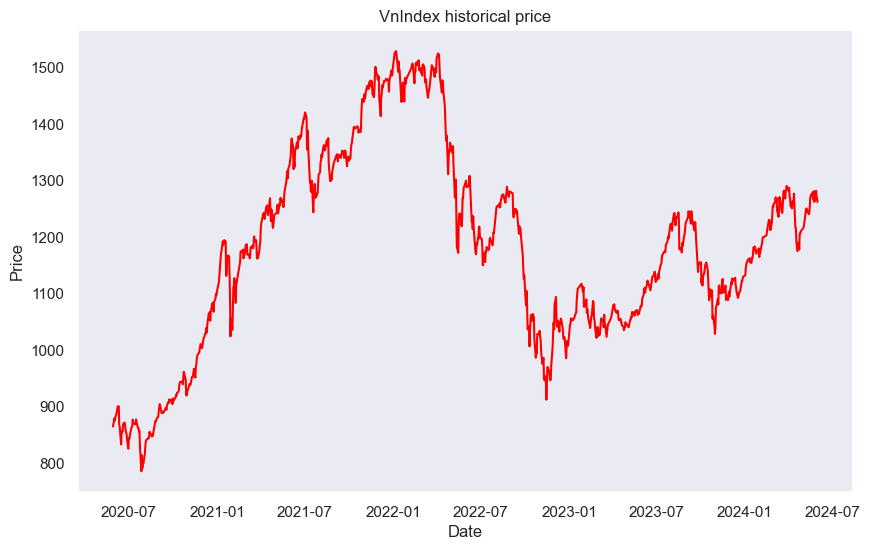

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=df1, x=df1.index, y='close', color='red')
plt.title('VnIndex historical price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.show()

In [220]:
df=df1.merge(df,how='left',left_on='Date',right_on='Date')
df

,Date,close,open,high,low,change,description
0,2020-05-29,864.47,861.59,866.95,859.26,0.0036,The National Assembly has begun scrutinising a...
1,2020-06-01,878.67,868.97,878.67,868.97,14.2000,The National Assembly Standing Committee resum...
2,2020-06-02,874.80,879.23,882.73,874.53,-3.8700,The construction plan of phase 1 of Long Thanh...
3,2020-06-03,881.17,876.73,881.17,874.01,6.3700,Big C Mien Dong supermarket (in Ho Chi Minh Ci...
4,2020-06-04,883.90,883.22,888.32,883.22,2.7300,Prime Minister Nguyen Xuan Phuc presided over ...
...,...,...,...,...,...,...,...
997,2024-05-27,1267.68,1263.46,1267.68,1257.27,5.7500,EVNNPT has mobilised more than 800 employees t...
998,2024-05-28,1281.73,1272.85,1281.73,1269.37,14.0500,The government has been urged to clear up the ...
999,2024-05-29,1272.64,1284.74,1285.63,1271.60,-9.0900,The journey towards building eco-friendly indu...
1000,2024-05-30,1266.32,1267.62,1269.07,1251.80,-6.3200,"With a 100 million-plus population, Vietnam’s ..."


In [221]:
df['label'] = df['change'].apply(lambda x: 1 if x >= 0 else 0)
df

,Date,close,open,high,low,change,description,label
0,2020-05-29,864.47,861.59,866.95,859.26,0.0036,The National Assembly has begun scrutinising a...,1
1,2020-06-01,878.67,868.97,878.67,868.97,14.2000,The National Assembly Standing Committee resum...,1
2,2020-06-02,874.80,879.23,882.73,874.53,-3.8700,The construction plan of phase 1 of Long Thanh...,0
3,2020-06-03,881.17,876.73,881.17,874.01,6.3700,Big C Mien Dong supermarket (in Ho Chi Minh Ci...,1
4,2020-06-04,883.90,883.22,888.32,883.22,2.7300,Prime Minister Nguyen Xuan Phuc presided over ...,1
...,...,...,...,...,...,...,...,...
997,2024-05-27,1267.68,1263.46,1267.68,1257.27,5.7500,EVNNPT has mobilised more than 800 employees t...,1
998,2024-05-28,1281.73,1272.85,1281.73,1269.37,14.0500,The government has been urged to clear up the ...,1
999,2024-05-29,1272.64,1284.74,1285.63,1271.60,-9.0900,The journey towards building eco-friendly indu...,0
1000,2024-05-30,1266.32,1267.62,1269.07,1251.80,-6.3200,"With a 100 million-plus population, Vietnam’s ...",0


Vì tin tức thường có xu hướng làm thay đổi diễn biến giá của VN Index vào ngày hôm sau, nên đề tài đã dùng tin tức hôm trước để đánh giá mối liên quan với sự biến động của VnIndex ngày hôm sau.

In [222]:
 df['description_1']=df['description'].shift(1)

In [223]:
import pandas as pd
df = df.iloc[1:].reset_index(drop=True)

In [224]:
df = df.drop('description', axis=1)
df

,Date,close,open,high,low,change,label,description_1
0,2020-06-01,878.67,868.97,878.67,868.97,14.20,1,The National Assembly has begun scrutinising a...
1,2020-06-02,874.80,879.23,882.73,874.53,-3.87,0,The National Assembly Standing Committee resum...
2,2020-06-03,881.17,876.73,881.17,874.01,6.37,1,The construction plan of phase 1 of Long Thanh...
3,2020-06-04,883.90,883.22,888.32,883.22,2.73,1,Big C Mien Dong supermarket (in Ho Chi Minh Ci...
4,2020-06-05,886.22,883.40,886.59,878.50,2.32,1,Prime Minister Nguyen Xuan Phuc presided over ...
...,...,...,...,...,...,...,...,...
996,2024-05-27,1267.68,1263.46,1267.68,1257.27,5.75,1,Mitsubishi Electric Corporation has announced ...
997,2024-05-28,1281.73,1272.85,1281.73,1269.37,14.05,1,EVNNPT has mobilised more than 800 employees t...
998,2024-05-29,1272.64,1284.74,1285.63,1271.60,-9.09,0,The government has been urged to clear up the ...
999,2024-05-30,1266.32,1267.62,1269.07,1251.80,-6.32,0,The journey towards building eco-friendly indu...


In [225]:
up = df[df['label']==1]
down = df[df['label']==0]
print(len(up)/len(df))

0.5764235764235764


In [226]:
df

,Date,close,open,high,low,change,label,description_1
0,2020-06-01,878.67,868.97,878.67,868.97,14.20,1,The National Assembly has begun scrutinising a...
1,2020-06-02,874.80,879.23,882.73,874.53,-3.87,0,The National Assembly Standing Committee resum...
2,2020-06-03,881.17,876.73,881.17,874.01,6.37,1,The construction plan of phase 1 of Long Thanh...
3,2020-06-04,883.90,883.22,888.32,883.22,2.73,1,Big C Mien Dong supermarket (in Ho Chi Minh Ci...
4,2020-06-05,886.22,883.40,886.59,878.50,2.32,1,Prime Minister Nguyen Xuan Phuc presided over ...
...,...,...,...,...,...,...,...,...
996,2024-05-27,1267.68,1263.46,1267.68,1257.27,5.75,1,Mitsubishi Electric Corporation has announced ...
997,2024-05-28,1281.73,1272.85,1281.73,1269.37,14.05,1,EVNNPT has mobilised more than 800 employees t...
998,2024-05-29,1272.64,1284.74,1285.63,1271.60,-9.09,0,The government has been urged to clear up the ...
999,2024-05-30,1266.32,1267.62,1269.07,1251.80,-6.32,0,The journey towards building eco-friendly indu...


In [227]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
def to_words(content):
    content = str(content)  
    letters = re.sub("[^a-zA-Z]", " ", content)
    words = letters.lower().split()
    stops = set(stopwords.words("english"))
    mwords = [w for w in words if not w in stops]
    return " ".join(mwords)
up_word = []
down_word = []
for word in up['description_1']:
    up_word.append(to_words(word))
for word in down['description_1']:
    down_word.append(to_words(word))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [228]:
down_word[0:5]

['national assembly standing committee resumed th session june adopted resolution stipulating principles criteria quota allocation public investment using state budget period natural resources consumed per cent faster replaced circular economy become ultimate goal big corporations recent years result insee vietnam approach green manufacturing focusing reducing use raw materials self production energy products potential recycle reuse back manufacturing process prime minister nguyen xuan phuc may requested southern key economic region strive become powerful prosperous region ten years ahead deadline goal whole vietnam',
 'starting year investors eu member states first time allowed tender many types public projects vietnam eu vietnam free trade agreement commitments enforcement landmark eu vietnam free trade agreement become reality within next months ushering multiple benefits sides three consecutive years top ranks provincial competitiveness index pci northeastern province quang ninh de

In [229]:
wordcloud_down = WordCloud(background_color='black',
                          width=3000,
                          height=2500
                          ).generate(down_word[0])

In [230]:
matplotlib.rcParams["figure.figsize"] = "8, 8"

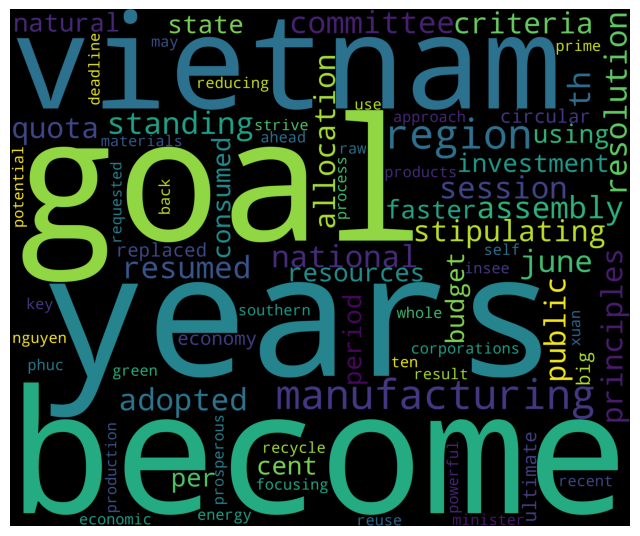

In [231]:
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud_down)
plt.axis('off')
plt.show()

In [234]:
wordcloud_up = WordCloud(background_color='white',
                         width=3000,
                         height=2500
                         ).generate(up_word[0])

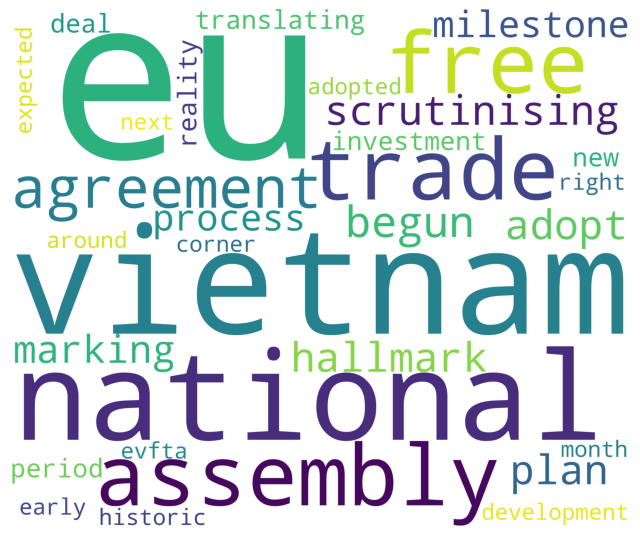

In [235]:
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud_up)
plt.axis('off')
plt.show()

In [236]:
#Splitting data into train and test
train, test = train_test_split(df,train_size=0.7,test_size=0.3,random_state=1)

In [237]:
train.shape

(700, 8)

In [238]:
test.shape

(301, 8)

In [239]:
traindescription = train['description_1'].tolist()

In [240]:
testdescription = test['description_1'].tolist()

In [241]:
testdescription_series = pd.Series(testdescription)

In [242]:
testdescription_series = testdescription_series.fillna('')

In [243]:
traindescription[2]

"Quang Ninh's foreign investment has exceeded $2 billion for the first time thanks to large-scale projects.\tBusinesses that intend to deploy rooftop solar energy for their own use must await a seamless link to the national energy grid.\tA new hallmark cooperation framework between Vietnam and South Korea will help both countries to expand trade and investment ties.\tAn 11-month large trade surplus has mirrored an expansion of both exports and imports, but lingering risks are making it difficult for the country to hit its trade goals next year.\tPrime Minister Pham Minh Chinh will pay an official visit to the Netherlands on December 13. Dutch Ambassador to Vietnam Kees van Baar spoke to VIR’s Thanh Tung about the trade and investment prospects between both nations."

In [244]:
traindescription_series = pd.Series(traindescription)

In [245]:
traindescription_series = traindescription_series.fillna('')

In [246]:
#Scikit-learn’s CountVectorizer is used to convert a collection of text documents to a vector of term/token counts.
#n=1 for this n-gram model
basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(traindescription_series)
print(basictrain.shape)


(700, 6327)


In [247]:
print(basicvectorizer.get_feature_names_out())

['000' '000ha' '000km' ... 'zurich' 'zuru' 'ørsted']


In [248]:
basictrain[0]

<1x6327 sparse matrix of type '<class 'numpy.int64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [249]:
print(basictrain.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [250]:
#We run 3 n-gram models using Random forest classifier and Logistic regression both. n=1, 2 and 3
#n=1, random forest
RFmodel1=RandomForestClassifier(n_estimators=200,criterion='entropy')
RFmodel1=RFmodel1.fit(basictrain,train['label'])

In [251]:
basictest = basicvectorizer.transform(testdescription_series)
preds1 = RFmodel1.predict(basictest)
acc1=accuracy_score(test['label'], preds1)

In [252]:
matrix=confusion_matrix(test['label'],preds1)
print(matrix)
score=accuracy_score(test['label'],preds1)
print(score)
report=classification_report(test['label'],preds1)
print(report)

[[  9 128]
 [ 13 151]]
0.53156146179402
              precision    recall  f1-score   support

           0       0.41      0.07      0.11       137
           1       0.54      0.92      0.68       164

    accuracy                           0.53       301
   macro avg       0.48      0.49      0.40       301
weighted avg       0.48      0.53      0.42       301



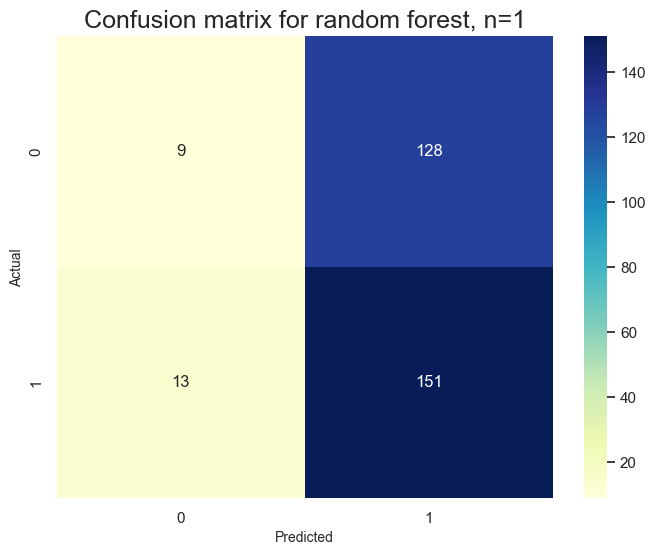

In [253]:
sn.set(font_scale=1.0)
plt.figure(figsize=(8, 6))
ax= sn.heatmap(matrix, cmap = "YlGnBu",annot=True, fmt="d")

plt.title('Confusion matrix for random forest, n=1',fontsize=18)
plt.xlabel('Predicted', fontsize = 10) 
plt.ylabel('Actual', fontsize = 10)
plt.show()

In [254]:
#n=1,logistic regression
LRmodel1 = LogisticRegression(max_iter=1000)
LRmodel1 = LRmodel1.fit(basictrain, train["label"])

In [255]:
basictest = basicvectorizer.transform(testdescription_series)
preds2 = LRmodel1.predict(basictest)
acc2=accuracy_score(test['label'], preds2)

In [256]:
matrix=confusion_matrix(test['label'],preds2)
print(matrix)
score=accuracy_score(test['label'],preds2)
print(score)
report=classification_report(test['label'],preds2)
print(report)

[[ 47  90]
 [ 52 112]]
0.5282392026578073
              precision    recall  f1-score   support

           0       0.47      0.34      0.40       137
           1       0.55      0.68      0.61       164

    accuracy                           0.53       301
   macro avg       0.51      0.51      0.51       301
weighted avg       0.52      0.53      0.51       301



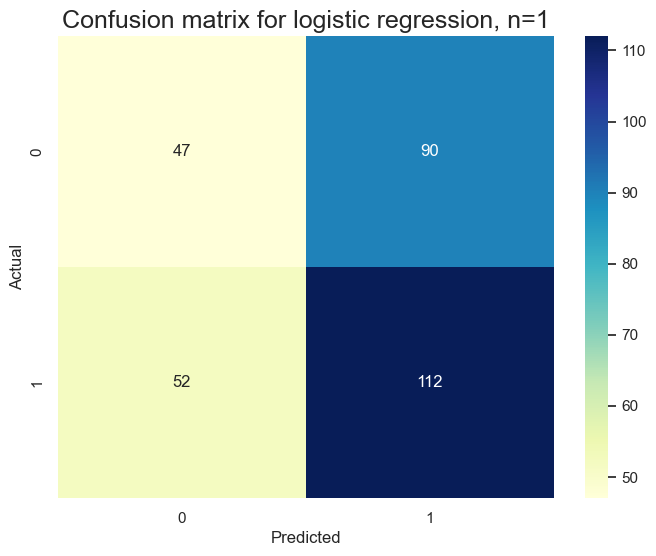

In [257]:
plt.figure(figsize=(8, 6)) 
ax = sn.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d")

plt.title('Confusion matrix for logistic regression, n=1', fontsize=18)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [258]:
# Top 5 positive co-efficients
basicwords = basicvectorizer.get_feature_names_out()
basiccoeffs = LRmodel1.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : basicwords, 
                        'Coefficient' : basiccoeffs})
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf.head(5)

,Word,Coefficient
3377,localities,0.740603
1537,deal,0.672228
4797,retail,0.609485
390,agency,0.607854
3750,nation,0.604681


In [259]:
# Top 5 negative co-efficients
coeffdf.tail(5)

,Word,Coefficient
1370,continuing,-0.682040
2550,green,-0.687347
417,aims,-0.733111
77,2022,-0.754360
94,22,-0.801704


In [260]:
#n=2
advancedvectorizer = TfidfVectorizer( min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))
advancedtrain = advancedvectorizer.fit_transform(traindescription_series)

In [261]:
print(advancedtrain.shape)

(700, 219)


In [262]:
print(advancedvectorizer.get_feature_names_out())

['19 pandemic' 'about the' 'according to' 'amid the' 'an mou'
 'and acquisitions' 'and business' 'and foreign' 'and investment'
 'and the' 'and trade' 'and vietnam' 'are expected' 'as the' 'as well'
 'at the' 'between the' 'between vietnam' 'billion usd' 'binh duong'
 'by the' 'cent of' 'central province' 'chairman of' 'chi minh' 'city of'
 'companies are' 'construction of' 'continue to' 'continues to' 'covid 19'
 'delta province' 'department of' 'despite the' 'destination for'
 'development of' 'digital transformation' 'direct investment'
 'director of' 'disbursement of' 'domestic and' 'dong nai' 'due to'
 'economic growth' 'efforts to' 'eu vietnam' 'expected to' 'factory in'
 'for foreign' 'for its' 'for the' 'for vietnam' 'foreign direct'
 'foreign invested' 'foreign investment' 'foreign investors' 'free trade'
 'from the' 'growth in' 'has been' 'have been' 'high quality' 'high tech'
 'ho chi' 'in foreign' 'in hanoi' 'in ho' 'in its' 'in order' 'in the'
 'in vietnam' 'industrial par

In [263]:
#Random forest, n=2
RFmodel2=RandomForestClassifier(n_estimators=500,criterion='entropy')
RFmodel2=RFmodel2.fit(advancedtrain,train['label'])

In [264]:
advancedtest = advancedvectorizer.transform(testdescription_series)
preds3 = RFmodel2.predict(advancedtest)
acc3=accuracy_score(test['label'], preds3)

In [265]:
matrix=confusion_matrix(test['label'],preds3)
print(matrix)
score=accuracy_score(test['label'],preds3)
print(score)
report=classification_report(test['label'],preds3)
print(report)

[[ 41  96]
 [ 46 118]]
0.5282392026578073
              precision    recall  f1-score   support

           0       0.47      0.30      0.37       137
           1       0.55      0.72      0.62       164

    accuracy                           0.53       301
   macro avg       0.51      0.51      0.50       301
weighted avg       0.51      0.53      0.51       301



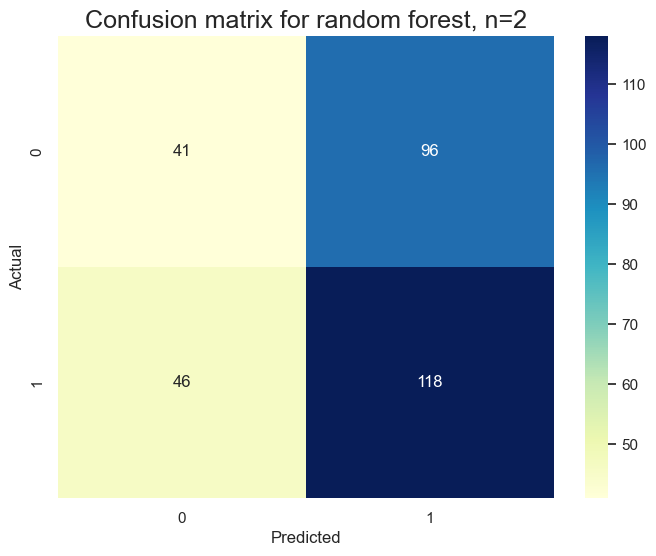

In [266]:
plt.figure(figsize=(8, 6)) 
ax = sn.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Confusion matrix for random forest, n=2', fontsize=18)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [267]:
#n=2, Logistic regression
LRmodel2 = LogisticRegression(max_iter=1000)
LRmodel2 = LRmodel2.fit(advancedtrain, train["label"])

advancedtest = advancedvectorizer.transform(testdescription_series)
preds4 = LRmodel2.predict(advancedtest)
acc4=accuracy_score(test['label'], preds4)

In [268]:
matrix=confusion_matrix(test['label'],preds4)
print(matrix)
score=accuracy_score(test['label'],preds4)
print(score)
report=classification_report(test['label'],preds4)
print(report)


[[ 27 110]
 [ 27 137]]
0.5448504983388704
              precision    recall  f1-score   support

           0       0.50      0.20      0.28       137
           1       0.55      0.84      0.67       164

    accuracy                           0.54       301
   macro avg       0.53      0.52      0.47       301
weighted avg       0.53      0.54      0.49       301



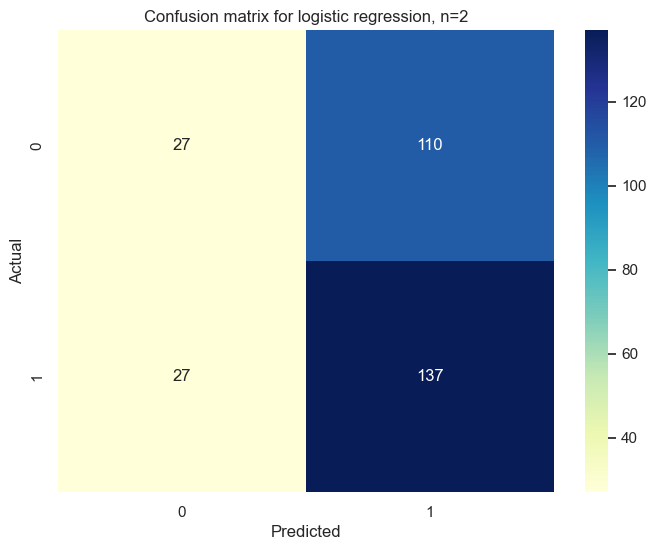

In [269]:
plt.figure(figsize=(8, 6))
ax= sn.heatmap(matrix, cmap = "YlGnBu",annot=True, fmt="d")
plt.title('Confusion matrix for logistic regression, n=2')
plt.xlabel('Predicted', fontsize = 12) 
plt.ylabel('Actual', fontsize = 12)
plt.show()

In [270]:
advancedwords = advancedvectorizer.get_feature_names_out()
advancedcoeffs = LRmodel2.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : advancedwords, 
                        'Coefficient' : advancedcoeffs})
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf.head(5)

,Word,Coefficient
206,vietnam as,1.224746
208,vietnam has,1.155122
161,the new,1.055653
123,per cent,1.017412
126,plans to,1.010780


In [271]:
coeffdf.tail(5)

,Word,Coefficient
113,of vietnam,-0.864781
53,foreign invested,-0.879210
217,with vietnam,-0.880985
77,into vietnam,-0.943348
155,the government,-1.070373


In [272]:
#n=3
advancedvectorizer2 = TfidfVectorizer( min_df=0.004, max_df=0.996, max_features = 200000, ngram_range = (3, 3))
advancedtrain2 = advancedvectorizer2.fit_transform(traindescription_series)

In [273]:
print(advancedtrain2.shape)

(700, 1886)


In [274]:
print(advancedvectorizer2.get_feature_names_out())

['10 months of' '10 per cent' '13 per cent' ... 'yen province is'
 'yoshida head of' 'zones management authority']


In [275]:
#random forest for n=3
RFmodel3=RandomForestClassifier(n_estimators=800,criterion='entropy')
RFmodel3=RFmodel3.fit(advancedtrain2,train['label'])

In [276]:
advancedtest2 = advancedvectorizer2.transform(testdescription_series)
preds5 = RFmodel3.predict(advancedtest2)
acc5=accuracy_score(test['label'], preds5)

In [277]:
matrix=confusion_matrix(test['label'],preds5)
print(matrix)
score=accuracy_score(test['label'],preds5)
print(score)
report=classification_report(test['label'],preds5)
print(report)

[[ 28 109]
 [ 23 141]]
0.5614617940199336
              precision    recall  f1-score   support

           0       0.55      0.20      0.30       137
           1       0.56      0.86      0.68       164

    accuracy                           0.56       301
   macro avg       0.56      0.53      0.49       301
weighted avg       0.56      0.56      0.51       301



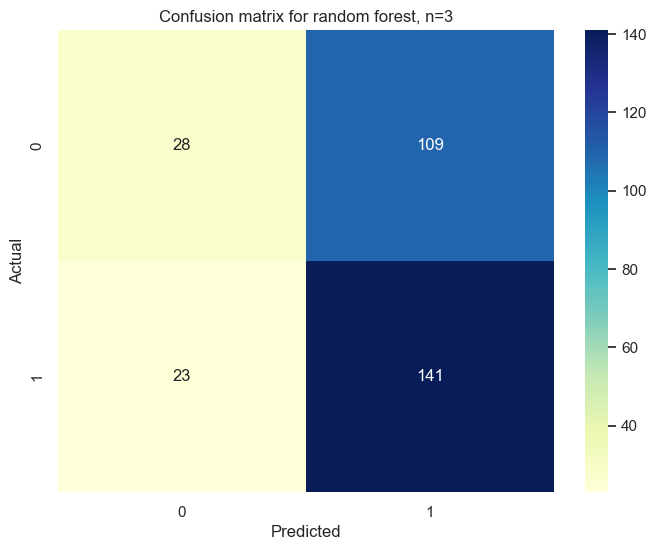

In [278]:
plt.figure(figsize=(8, 6))
ax= sn.heatmap(matrix, cmap = "YlGnBu",annot=True, fmt="d")
plt.title('Confusion matrix for random forest, n=3')
plt.xlabel('Predicted', fontsize = 12) 
plt.ylabel('Actual', fontsize = 12)
plt.show()

In [279]:
#logistic regression for n=3
LRmodel3 = LogisticRegression(max_iter=1000)
LRmodel3 = LRmodel3.fit(advancedtrain2, train["label"])

In [280]:
advancedtest2 = advancedvectorizer2.transform(testdescription_series)
preds6 = LRmodel3.predict(advancedtest2)
acc6=accuracy_score(test['label'], preds6)

In [281]:
matrix=confusion_matrix(test['label'],preds6)
print(matrix)
score=accuracy_score(test['label'],preds6)
print(score)
report=classification_report(test['label'],preds6)
print(report)

[[ 14 123]
 [ 12 152]]
0.5514950166112956
              precision    recall  f1-score   support

           0       0.54      0.10      0.17       137
           1       0.55      0.93      0.69       164

    accuracy                           0.55       301
   macro avg       0.55      0.51      0.43       301
weighted avg       0.55      0.55      0.46       301



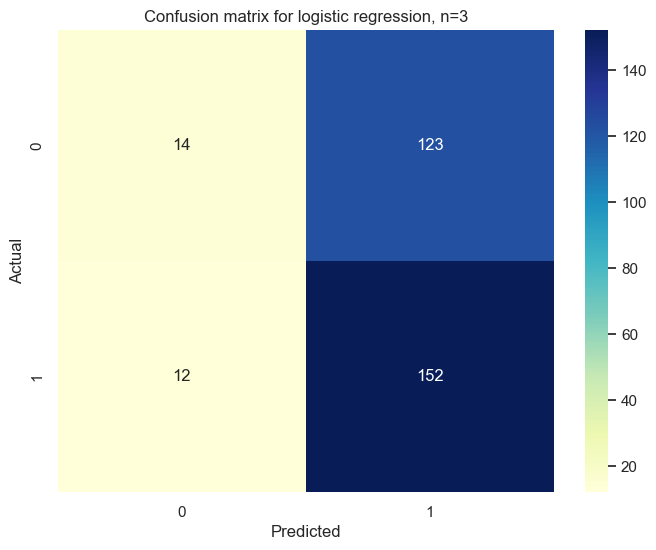

In [282]:
plt.figure(figsize=(8, 6))
ax= sn.heatmap(matrix, cmap = "YlGnBu",annot=True, fmt="d")
plt.title('Confusion matrix for logistic regression, n=3')
plt.xlabel('Predicted', fontsize = 12) 
plt.ylabel('Actual', fontsize = 12)
plt.show()

In [283]:
advancedwords2 = advancedvectorizer2.get_feature_names_out()
advancedcoeffs2 = LRmodel3.coef_.tolist()[0]
coeffdf2 = pd.DataFrame({'Word' : advancedwords2, 
                        'Coefficient' : advancedcoeffs2})
coeffdf2 = coeffdf2.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf2.head(5)

,Word,Coefficient
1570,the vietnam forum,0.616901
25,across the country,0.610576
906,ministry of transport,0.580677
755,investment in vietnam,0.568878
23,acquisitions in vietnam,0.560385


In [284]:
coeffdf2.tail(5)

,Word,Coefficient
327,despite covid 19,-0.646762
479,foreign invested enterprises,-0.741786
1353,that it has,-0.783934
1049,of the pandemic,-0.797637
1439,the government has,-1.092698
